###  Using Long Short Term Memory (LSTM) for stock price prediction

[LSTM](https://en.wikipedia.org/wiki/Long_short-term_memory) is a type of artificial recurrent neural network, which is used in field of deep learning. It has feed back connections and can process sequence of data points.LSTM neural network can be used for short term movement of stocks over a long period of time. To predict stock prices,I will use a window of previous periods to predict the stock prices.


## Installing Libraries

In [1]:
%%capture
!pip install yfinance
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install joblib
!pip install seaborn
!pip install numpy
!pip install chart_studio
## https://github.com/Worlddatascience/DataScienceCohort/blob/master/6_How_to_Create_a_Candlestick_Chart_using_Python.ipynb
!pip install cufflinks
## Code to Install Backtrader
!pip install backtrader 
!pip install pandas_datareader
!pip install scikit-learn
! pip install keras
! pip install tensorflow
! pip install pmdarima


### Importing Libraries

In [2]:
import warnings

warnings.filterwarnings('ignore')

import datetime
import yfinance

import numpy as np
import pandas as pd
from pandas_datareader.data import DataReader
import matplotlib.pyplot as plt
import seaborn as sns
import functools
from pandas.tseries.offsets import BDay

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.metrics import confusion_matrix

import pmdarima
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

from collections import deque
import random
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()

### Creating a data frame for different tickers

In [3]:
def dft(name='QQQ',frequency='1d',first="2010-07-01",last="2022-11-30"):
    ticker = yfinance.Ticker(name)
    stock = ticker.history(interval=frequency,start=first,end=last)
    data=stock.loc[:, ["Close"]]
    return data

In [4]:
df=dft("QQQ")

###  Developing daily, weekly,monthly actual and normalized data frames

In [5]:
# Resample the data weekly and monthly and do the same for the normalized data
stock_prices_daily=df.loc[:, ["Close"]]
#stock_prices_daily=pd
stock_prices_daily_normalized=df['Close'].div(df['Close'].max())
stock_prices_weekly = df['Close'].resample('W').mean()
stock_prices_weekly_normalized = stock_prices_daily_normalized.resample('W').mean()

stock_prices_monthly = df['Close'].resample('M').mean()
stock_prices_monthly_normalized = stock_prices_daily_normalized.resample('M').mean()

In [6]:
type(stock_prices_daily)

pandas.core.frame.DataFrame

###  Calculating percentage change for different period of data

In [7]:
## Calculate the returns for daily, weekly and monthly 

stock_returns_daily = stock_prices_daily.pct_change().dropna()

stock_returns_weekly = stock_prices_weekly.pct_change().dropna()

stock_returns_monthly = stock_prices_monthly.pct_change().dropna()

### Function for calculating returns for  user defined period 

In [8]:
# Multi Period Return

def multi_period_return(period_returns):
    return np.prod(period_returns + 1) - 1

stock_returns_daily_pr = stock_returns_daily.rolling('360D').apply(multi_period_return)

In [9]:
stock_returns_daily_pr.head()

,Close
Date,
2010-07-02 00:00:00-04:00,-0.002818
2010-07-06 00:00:00-04:00,0.000235
2010-07-07 00:00:00-04:00,0.032167
2010-07-08 00:00:00-04:00,0.037802
2010-07-09 00:00:00-04:00,0.047664


### Function for scaling data using Min-Max Scaling

In [10]:
# Define a function to use MaxMin Scaler for the modeling part

def scaler(train_array, test_array):
    scaler = MinMaxScaler(feature_range = (0,1))
    a = train_array.reshape(-1,1)
    b = test_array.reshape(-1,1)
    scaler = scaler.fit(a)
    X = scaler.transform(a)
    y = scaler.transform(b)
    return X, y

### Function for calculating real stock price from  scaled price

In [11]:
# Define a function to calculate the real price of the stock based on the MinMax Scaler

def scaler_inverse(train_array, predictions):
    scaler = MinMaxScaler(feature_range = (0,1))
    c = train_array.reshape(-1,1)
    scaler.fit(c)
    y_inverse = scaler.inverse_transform(predictions)
    return y_inverse

### Function for no. of days to be used as features in the time series

In [12]:
# Define a function to have the previous 5 days as independant features to predict the stock price

def preprocessing(dataset, time_steps = 1):
    X, y = [], []
    for i in range(len(dataset) - time_steps - 1):
        x = dataset[i:(i + time_steps), 0]
        X.append(x)
        y.append(dataset[i + time_steps, 0])
    return X, y

### Splitting our data frame into train and test

In [13]:
# Divide the train and test data
test_size = 60
train = df[:-test_size]
test = df[-test_size:]


###  Defining the size of array in the dataframe based on number of stocks

In [14]:
# Define an empty array to change the shape of the X variable (train and test)
# The new shape with treat the stock prices as each of the subarrays
# Eight stocks mean an array with shape (8, n_days)

n_days = len(stock_prices_daily)

# Define number of stocks

n_stocks = len(stock_prices_daily.columns)

# Save the number of days that are going to be used as train and test

n_days_train = len(train)
n_days_test = len(test)

# Empty array for the train and test data

train_scale = np.zeros(shape = (n_stocks, n_days_train))

test_scale = np.zeros(shape = (n_stocks, n_days_test))

# Use the for loop to iterate over the train and test to have the array shape changed

for i in range(0, n_stocks):
    train_scale[i] = train.iloc[:,i]
    
for i in range(0, n_stocks):
    test_scale[i] = test.iloc[:,i]

###  Creating empty arrays for training and test data after scaling

In [15]:
# Empty arrays for the train and test data (n_stocks, ndays, 1) to make it usable after using the MinMax Scaler

Xtrain = np.empty(shape = (n_stocks, n_days_train, 1))

Xtest = np.empty(shape = (n_stocks, n_days_test, 1))

# For loop to create the Xtrain and Xtest and scale the data (by just fitting the train data). 
# The idea is to avoid the data leakage by scaling the complete data set

for i in range(n_stocks):
    Xtrain[i], Xtest[i] = scaler(train_array = train_scale[i], test_array = test_scale[i])

### Merging both train and test data for applying feature engineering

In [16]:
# Get together the Xtrain and Xtest to apply some feature engineering (Make previous 5 days as independent variables)
# and the day ahead the dependant variable

# Define the empty array to iterate over an array (more time efficient)

Values = np.empty(shape = (n_stocks, n_days, 1))

#Iterate by concatenating the Xtrain and Xtest

for i in range(n_stocks):
    Values[i] = np.concatenate((Xtrain[i], Xtest[i]))

###  No. of days to be used as features for neural network

In [17]:
# Use the function to use the previous 5 days as independent features for train data

time_steps = 5

# Make two empty list to store the data

X = []
y = []

for i in range(0, n_stocks):
    # Use the preprocessing function 
    a,b = preprocessing(dataset = Values[i], time_steps = time_steps)
    # Apend the values
    X.append(a)
    y.append(b)

# Make sure to have them as arrays

X = np.array(X)
y = np.array(y)

###  Reshaping the arrays for taking 5 days as variables

In [18]:
# X_train array will have new shape

# Define the new days for each subarray

n_days_train_resample = n_days_train - time_steps - 1

# Make empty arrays with the reshape of the data after taking the 5 days as independant variables

X_train = np.empty(shape = (n_stocks, n_days_train_resample, 5))

y_train = np.empty(shape = (n_stocks, n_days_train_resample))

X_test = np.empty(shape = (n_stocks, n_days_test, 5))

y_test = np.empty(shape = (n_stocks, n_days_test))

In [19]:
# Start for the X_train, y_train, X_test, y_test

for i in range(n_stocks):
    X_train[i], y_train[i] = X[i][:n_days_train_resample], y[i][:n_days_train_resample]
    X_test[i], y_test[i] = X[i][n_days_train_resample:], y[i][n_days_train_resample:]

###  Reshaping inputs for LSTM 

In [20]:
# Reshape input to be [samples, time steps, features] which is required for LSTM

X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , X_test.shape[2], 1)

### Checking the shape of our train and test data for modelling

In [21]:
print('Shape of the train data to use at the model', X_train.shape, y_train.shape)
print('Shape of the test data to use', X_test.shape, y_test.shape)

Shape of the train data to use at the model (1, 3060, 5, 1) (1, 3060)
Shape of the test data to use (1, 60, 5, 1) (1, 60)


### Function for neural network
- Optimizer='adam'
- loss function="mean squared error

In [22]:
# Define a model to build the neural network

def neural_network():
    # Begin with Sequential
    regressor = Sequential()
    # The first layer would the be LSTM
    regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (5,1)))
    regressor.add(Dropout(0.2))
    regressor.add(LSTM(units = 50, return_sequences = True))
    regressor.add(Dropout(0.2))
    regressor.add(LSTM(units = 50))
    regressor.add(Dropout(0.2))
    regressor.add(Dense(units = 1))
    regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
    return regressor

### Function for reshaping train and test data for use on neural network

In [23]:
# Define a variable to reshape the train and test data into shape (, , 1) to make it processable on the neural network

def variables_model(n):
    x_train, Y_train = X_train[n], y_train[n]
    x_test, Y_test = X_test[n], y_test[n]
    
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
    x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
    
    return (x_train, x_test, Y_train, Y_test)
    

### Function for fitting the model with epochs=50

In [24]:
# Fit the model and get the predictions

def model_fit(Xtr, ytr, Xte):
    model.fit(Xtr, ytr, epochs = 50, batch_size = 32)
    pred = model.predict(Xte)
    return pred

### Merging the actual and prediction data for further analysis

In [25]:
# For future use in plotting, create one data frame to have the train values plus the test values
# and another pandas series to have the train data plus the predicted values

def df_merger(train_data, test_data, pred_values):
    actual_data = train_data.append(test_data)
    predicted_data = train_data.append(pred_values)
    return actual_data, predicted_data

### Defining a function for comparing plots

In [26]:
# Compare actual values with predicted values with a plot

def plot_comparison(actual, predicted, string):
    #Visualizing the prediction
    plt.figure(figsize=(10,6))
    plt.plot(actual[:-test_size], color = 'blue')
    plt.plot(actual[-test_size:], color = 'orange', label = 'Actual Values')
    plt.plot(predicted[-test_size:], color = 'green', label = 'Predicted Values')
    plt.title(string)
    plt.xlabel('Trading Day')
    plt.ylabel('Price')
    plt.legend()
    return plt.show()
    

### Creating a data frame for saving all predictions

In [27]:
# Save a data frame to concat all the predictions

# Start with an empty data frame
predictions_df = pd.DataFrame()

# Start with the same date than the test for the comparisons.
predictions_df['Date'] = test.index

#Set the date as the index
predictions_df.set_index('Date', inplace = True)

### Modeling

In [28]:
# Define the model

model = neural_network()

In [29]:
# Check the summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 50)             10400     
                                                                 
 dropout (Dropout)           (None, 5, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 5, 50)             20200     
                                                                 
 dropout_1 (Dropout)         (None, 5, 50)             0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

### Recalling data for the stock QQQ

In [30]:
# Get the data for this stock

Q_Xtrain, Q_Xtest, Q_ytrain, Q_ytest = variables_model(n = 0)

### Fitting the data in LSTM 

In [31]:
# Fit the data for the stock

Q_pred = model_fit(Xtr = Q_Xtrain, ytr = Q_ytrain, Xte = Q_Xtest)


Train on 3060 samples
Epoch 1/50
3060/3060 [==============================] - 1s 460us/sample - loss: 0.0203
Epoch 2/50
3060/3060 [==============================] - 1s 167us/sample - loss: 0.0021
Epoch 3/50
3060/3060 [==============================] - 1s 171us/sample - loss: 0.0018
Epoch 4/50
3060/3060 [==============================] - 1s 170us/sample - loss: 0.0017
Epoch 5/50
3060/3060 [==============================] - 0s 163us/sample - loss: 0.0014
Epoch 6/50
3060/3060 [==============================] - 1s 167us/sample - loss: 0.0014
Epoch 7/50
3060/3060 [==============================] - 0s 160us/sample - loss: 0.0014
Epoch 8/50
3060/3060 [==============================] - 0s 158us/sample - loss: 0.0013
Epoch 9/50
3060/3060 [==============================] - 1s 170us/sample - loss: 0.0012
Epoch 10/50
3060/3060 [==============================] - 0s 160us/sample - loss: 0.0013
Epoch 11/50
3060/3060 [==============================] - 0s 163us/sample - loss: 0.0011
Epoch 12/50
3060/30

### Getting the real price of stock by inverse scaling

In [32]:
# Use the inverse transform function

Q_pred_prices = scaler_inverse(train_array = train['Close'].values, predictions = Q_pred)


### Adding predicted price in the data frame

In [33]:
# Add the first column to the data frame that will store the predictions

predictions_df['Close'] = Q_pred_prices


### Getting actual and predicted data from our model

In [34]:
# Get the actual and predicted data as data frames for both

QQQ_actual, QQQ_predicted = df_merger(train_data = train['Close'], test_data = test['Close'], 
                                  pred_values = predictions_df['Close'])


### Verifying actual data

In [35]:
#QQQ_actual.info()
#df1.info()
QQQ_actual.tail()

Date
2022-11-22 00:00:00-05:00    285.267059
2022-11-23 00:00:00-05:00    288.130188
2022-11-25 00:00:00-05:00    286.234741
2022-11-28 00:00:00-05:00    282.034790
2022-11-29 00:00:00-05:00    279.899902
Name: Close, dtype: float64

In [36]:
len(QQQ_predicted)

3126

### Comparing the actual and predicted values by plot

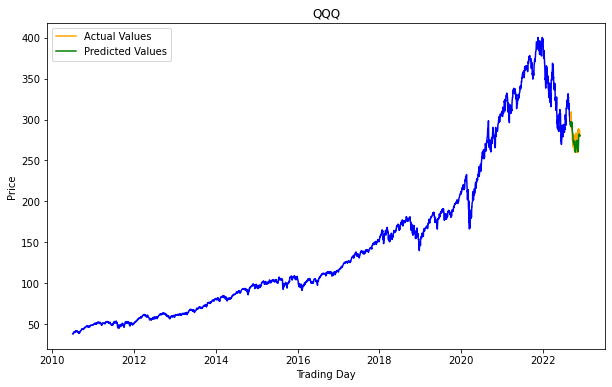

In [37]:
# Plot the QQQ Stock Price comparison

plot_comparison(actual = QQQ_actual, predicted = QQQ_predicted, string = 'QQQ')

#### Summary
- LSTM neural network can be used for predicting the stock prices. However, it may be affected by economic conditions, earning results and over all sentiments
- No of layers of LSTM can be modified for getting better predictability

#### Future Work

- Reinforcement learning can be applied to stocks data to see if it can improve predictions of  stock prices. 